In [3]:
from graphdatascience import GraphDataScience
import pandas as pd
import umap
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from getpass import getpass

# Connect to Neo4j

In [4]:
bolt_url = "bolt://54.196.239.38:7687"

In [5]:
gds = GraphDataScience(bolt_url, auth=("neo4j", getpass("Neo4j password")))

# Create gameVector property on Stream nodes as 1-hot encoding of games played

In [13]:
gds.run_cypher("""
MATCH (g:Game)
WITH g ORDER BY g.name
WITH collect(g) AS games
MATCH (s:Stream)
WITH games, s
CALL {
    WITH games, s
    WITH s, reduce( gameVector = [], g IN games | gameVector + [COUNT { (s)-[:PLAYS]->(g)}]) AS gameVector
    CALL db.create.setNodeVectorProperty(s, "gameVector", gameVector)
} IN CONCURRENT TRANSACTIONS OF 100 ROWS""")

""


# Create graph projection

In [15]:
gds.graph.drop("gameVectors")

g_games, result = gds.graph.cypher.project("""
    MATCH (s1:Stream)-[r:HAS_SIMILAR_INTERACTORS]->(s2:Stream)
    WHERE s1.gameVector IS NOT NULL AND s2.gameVector IS NOT NULL
    RETURN gds.graph.project(
        "gameVectors",
        s1,
        s2,
        {
            sourceNodeProperties: s1{.gameVector},
            targetNodeProperties: s2{.gameVector},
            relationshipProperties: r{.similarity},
            relationshipType: "HAS_SIMILAR_CONTACTS"
        },
        {
            undirectedRelationshipTypes: ["HAS_SIMILAR_CONTACTS"]
        })"""
)
result

relationshipCount                                                33392
graphName                                                  gameVectors
query                \n    MATCH (s1:Stream)-[r:HAS_SIMILAR_INTERAC...
projectMillis                                                      684
configuration        {'readConcurrency': 4, 'undirectedRelationship...
nodeCount                                                         4421
dtype: object

In [21]:
games_df = gds.graph.nodeProperty.stream(g_games, "gameVector")

# Find the most popular game played by Streamer
Most streamers play only one game. For streamers that play more than one, get the game that is played by the most other people. We'll use this for coloring visualizations.

In [48]:
popular_game_df = gds.run_cypher("""
MATCH (g:Game)
WHERE g.name <> ""
WITH g, COUNT{(:Stream)-[:PLAYS]->(g)} AS streams
ORDER BY streams DESC
WITH collect(g) AS games
MATCH (s:Stream)
WITH s, games, COLLECT {MATCH (s)-[:PLAYS]->(g) RETURN g} AS playedGames
RETURN id(s) AS nodeId, 
COALESCE(REDUCE(game=null, g in games[..20] | CASE WHEN game IS NOT NULL THEN game WHEN g in playedGames THEN g.name END), "Other") AS mostPopularPlayedGame,
[g in playedGames | g.name] AS allPlayedGames
                         """)

In [49]:
games_df = games_df.merge(popular_game_df, on="nodeId")

In [23]:
games_df.rename({"propertyValue": "gameVector"}, axis=1, inplace=True)
games_df.head()

,nodeId,gameVector,nodeLabels
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[]
1,2940898,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[]
2,1441694,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[]
3,1206109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[]
4,4989904,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[]


# Run fastRP with and without properties

In [19]:
gds.fastRP.write(g_games, 
                 propertyRatio = 1.0,
                 featureProperties = ["gameVector"],
                 embeddingDimension = 256,
                 iterationWeights = [0.0, 1.0, 1.0],
                 randomSeed = 24,                               
                 relationshipWeightProperty = "similarity",
                 writeProperty = "fastRPGameEmbedding")

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

nodeCount                                                             4421
nodePropertiesWritten                                                 4421
preProcessingMillis                                                      0
computeMillis                                                          906
writeMillis                                                            309
configuration            {'writeProperty': 'fastRPGameEmbedding', 'rand...
Name: 0, dtype: object

In [20]:
fastRP_game_df = gds.run_cypher("MATCH s:Stream WHERE fastRPGameEmbedding IS NOT NULL RETURN id(s) AS nodeId, s.fastRPGameEmbedding AS fastRP_game_embedding")

In [24]:
games_df = games_df.merge(fastRP_game_df, on="nodeId")

In [74]:
gds.fastRP.write(g_games, 
                               embeddingDimension = 256,
                               iterationWeights = [0.0, 1.0, 1.0],
                               randomSeed = 24,                               
                               relationshipWeightProperty = "similarity",
                               writeProperty="fastRPNoPropsEmbedding")

nodeCount                                                             4421
nodePropertiesWritten                                                 4421
preProcessingMillis                                                      0
computeMillis                                                          359
writeMillis                                                           1298
configuration            {'writeProperty': 'fastRPNoGameEmbedding', 'ra...
Name: 0, dtype: object

In [27]:
fastRP_no_props_df = gds.run_cypher("MATCH s:Stream WHERE fastRPNoPropsEmbedding IS NOT NULL RETURN id(s) AS nodeId, s.fastRPNoPropsEmbedding AS fastRP_no_property_embedding")

In [28]:
games_df = games_df.merge(fastRP_no_props_df, on="nodeId")

# Run WCC
Visualizations will make more sense with isolated nodes excluded.

In [29]:
wcc_df = gds.wcc.stream(g_games)
games_df = games_df.merge(wcc_df, on="nodeId")

# Use UMAP to reduce embeddings to two dimensions for plotting

In [31]:
reducer = umap.UMAP(n_components=2)

In [32]:
games_vector_reduced = reducer.fit_transform(np.array(list(games_df['gameVector'])))
games_umap_df = pd.DataFrame(games_vector_reduced, columns=['games_umap1', 'games_umap2'])
games_df = pd.concat([games_df, games_umap_df], axis=1)

In [34]:
fastrp_property_reduced = reducer.fit_transform(np.array(list(games_df['fastRP_game_embedding'])))
fastRP_prop_umap_df = pd.DataFrame(fastrp_property_reduced, columns=['fastRP_game_umap1', 'fastRP_game_umap2'])
games_df = pd.concat([games_df, fastRP_prop_umap_df], axis=1)

In [35]:
fastrp_no_prop_reduced = reducer.fit_transform(np.array(list(games_df['fastRP_no_property_embedding'])))
fastRP_no_prop_umap_df = pd.DataFrame(fastrp_no_prop_reduced, columns=['fastRP_no_property_umap1', 'fastRP_no_property_umap2'])
games_df = pd.concat([games_df, fastRP_no_prop_umap_df], axis=1)

In [41]:
games_df['game_count'] = games_df['gameVector'].map(np.sum)

In [42]:
games_df.head()

,nodeId,gameVector,nodeLabels,fastRP_property_embedding,fastRP_no_property_embedding,componentId,games_umap1,games_umap2,fastRP_property_umap1,fastRP_property_umap2,fastRP_no_property_umap1,fastRP_no_property_umap2,game_count
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[-0.0011627560015767813, -0.001843767124228179...","[-0.16652213037014008, -0.2435559630393982, 0....",0,14.525509,2.662243,16.302937,-1.881416,6.066461,12.421879,1.0
1,2940898,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[-0.001232028123922646, -0.0019295632373541594...","[-0.1909017562866211, -0.2819909453392029, -0....",0,12.795364,3.189353,16.299332,-1.877895,6.069092,12.421774,1.0
2,1441694,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[-0.0011652690591290593, -0.001849297899752855...","[-0.1870703399181366, -0.2651914954185486, -0....",0,12.859341,3.198350,16.303177,-1.882088,6.066877,12.424394,1.0
3,1206109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[-0.000472383078886196, -0.00215864647179842, ...","[-0.19696083664894104, -0.276045560836792, 0.0...",0,12.523437,1.311697,16.304279,-1.882758,6.064300,12.430557,1.0
4,4989904,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[-0.0015157003654167056, -0.001197222387418151...","[-0.18962106108665466, -0.28245675563812256, -...",0,12.797752,3.175339,16.285048,-1.863870,6.066305,12.425187,1.0


# Visualize embeddings

In [52]:
fig = px.scatter(games_df, x='games_umap1', y='games_umap2', color='mostPopularPlayedGame', hover_data=['game_count', 'allPlayedGames', 'nodeId'], width=1100, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [53]:
fig = px.scatter(games_df[games_df['componentId']==0], x='fastRP_property_umap1', y='fastRP_property_umap2', color='mostPopularPlayedGame', hover_data=['game_count', 'allPlayedGames', 'nodeId'], width=1100, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [55]:
fig = px.scatter(games_df[games_df['componentId']==0], x='fastRP_no_property_umap1', y='fastRP_no_property_umap2', color='mostPopularPlayedGame', hover_data=['game_count', 'nodeId'], width=1100, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

# Create vector indexes for embeddings 

In [69]:
gds.run_cypher("""
               CREATE VECTOR INDEX gameVector IF NOT EXISTS 
               FOR (n:Stream) ON (n.gameVector) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 594,
               `vector.similarity_function`: 'COSINE'}}""")

""


In [70]:
gds.run_cypher("""
               CREATE VECTOR INDEX fastRPNoGameEmbedding IF NOT EXISTS 
               FOR (n:Stream) ON (n.fastRPNoGameEmbedding) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 256,
               `vector.similarity_function`: 'COSINE'}}""")

""


In [71]:
gds.run_cypher("""
               CREATE VECTOR INDEX fastRPGameEmbedding IF NOT EXISTS 
               FOR (n:Stream) ON (n.fastRPGameEmbedding) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 256,
               `vector.similarity_function`: 'COSINE'}}""")

""


# Find the five most similar nodes for each streamer based on embeddings 
Find out if the neighbors are within 2 hops of the streamer, how many games they play in common, and whether their description is in the same language.

(Language detection was run on descriptions in the DescriptionEmbedding.ipynb notebook.)

In [139]:
prop_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPGameEmbedding IS NOT NULL
WITH s
CALL db.index.vector.queryNodes("fastRPGameEmbedding", 6, s.fastRPGameEmbedding) 
YIELD node, score
WHERE node <> s
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(node)} THEN 1 ELSE 0 END AS pathCount, 
CASE WHEN EXISTS { (s)-[:PLAYS]->()<-[:PLAYS]-(node)} THEN 1 ELSE 0 END AS sharedGameCount,
CASE WHEN s.language = node.language THEN 1 ELSE 0 END AS languageMatch""")

In [140]:
no_prop_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPGameEmbedding IS NOT NULL
WITH s
CALL db.index.vector.queryNodes("fastRPNoGameEmbedding", 6, s.fastRPNoGameEmbedding) 
YIELD node, score
WHERE node <> s
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(node)} THEN 1 ELSE 0 END AS pathCount, 
CASE WHEN EXISTS { (s)-[:PLAYS]->()<-[:PLAYS]-(node)} THEN 1 ELSE 0 END AS sharedGameCount,
CASE WHEN s.language = node.language THEN 1 ELSE 0 END AS languageMatch""")

# Find pairs of streamers who play the same game

In [149]:
game_neighbors_df = gds.run_cypher("""
MATCH (s1:Stream)-[:PLAYS]->()<-[:PLAYS]-(s2)
WHERE s1.fastRPNoGameEmbedding IS NOT NULL
AND s2.fastRPNoGameEmbedding IS NOT NULL
AND s1 < s2
WITH DISTINCT s1, s2
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(s2)} THEN 1 ELSE 0 END AS pathCount, 
CASE WHEN s1.language = s2.language THEN 1 ELSE 0 END AS languageMatch,
gds.similarity.cosine(s1.fastRPGameEmbedding, s2.fastRPGameEmbedding) AS fastRPPropertySim,
gds.similarity.cosine(s1.fastRPNoGameEmbedding, s2.fastRPNoGameEmbedding) AS fastRPNoPropertySim""")

In [142]:
prop_neighbors_df.apply('mean')

pathCount          0.759943
sharedGameCount    0.469077
languageMatch      0.304853
dtype: float64

In [143]:
no_prop_neighbors_df.apply('mean')

pathCount          0.901220
sharedGameCount    0.391096
languageMatch      0.343137
dtype: float64

In [151]:
game_neighbors_df.apply('mean')

pathCount              1.000000
languageMatch          0.119682
fastRPPropertySim      0.588591
fastRPNoPropertySim    0.051141
dtype: float64

Stream nodes that share a game will be closer in the property based embedding space than the non-property-based embedding space.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



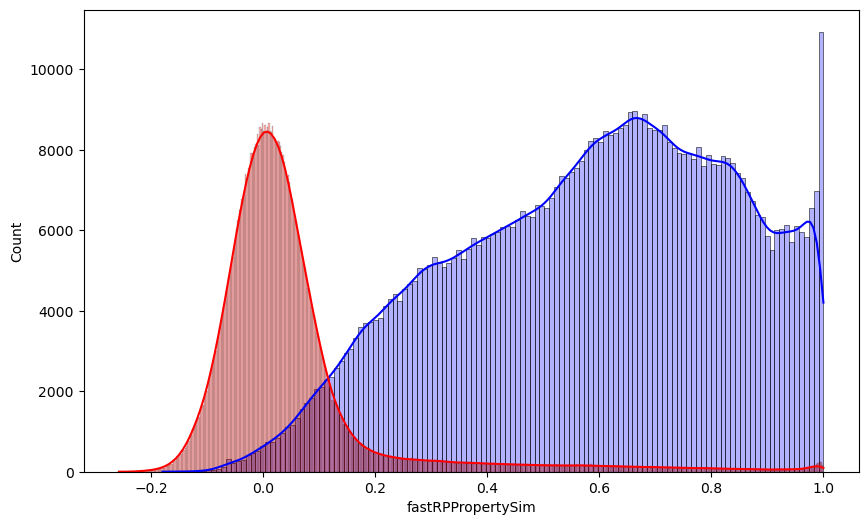

In [152]:
plt.figure(figsize=(10, 6))

sns.histplot(data=game_neighbors_df, x='fastRPPropertySim', kde=True, color='blue', alpha=0.3, label='FastRP with properties')
sns.histplot(data=game_neighbors_df, x='fastRPNoPropertySim', kde=True, color='red', alpha=0.3, label='FastRP without properties')

plt.show()